<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/NN_pytorch_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Neural Network=

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch import nn
from torch import optim
import torch.nn.functional as F

#define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


In [3]:
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw




Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw




Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw




Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        # print(layer_sizes)
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [8]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
        model.train()

Epoch: 1/2..  Training Loss: 1.298..  Test Loss: 0.757..  Test Accuracy: 0.727
Epoch: 1/2..  Training Loss: 0.845..  Test Loss: 0.661..  Test Accuracy: 0.748
Epoch: 1/2..  Training Loss: 0.749..  Test Loss: 0.609..  Test Accuracy: 0.775
Epoch: 1/2..  Training Loss: 0.656..  Test Loss: 0.599..  Test Accuracy: 0.773
Epoch: 1/2..  Training Loss: 0.655..  Test Loss: 0.554..  Test Accuracy: 0.791
Epoch: 1/2..  Training Loss: 0.623..  Test Loss: 0.531..  Test Accuracy: 0.801
Epoch: 1/2..  Training Loss: 0.590..  Test Loss: 0.525..  Test Accuracy: 0.806
Epoch: 1/2..  Training Loss: 0.599..  Test Loss: 0.524..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.588..  Test Loss: 0.516..  Test Accuracy: 0.814
Epoch: 1/2..  Training Loss: 0.569..  Test Loss: 0.492..  Test Accuracy: 0.823
Epoch: 1/2..  Training Loss: 0.546..  Test Loss: 0.503..  Test Accuracy: 0.814
Epoch: 1/2..  Training Loss: 0.546..  Test Loss: 0.507..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.535..  Test Loss: 0.4

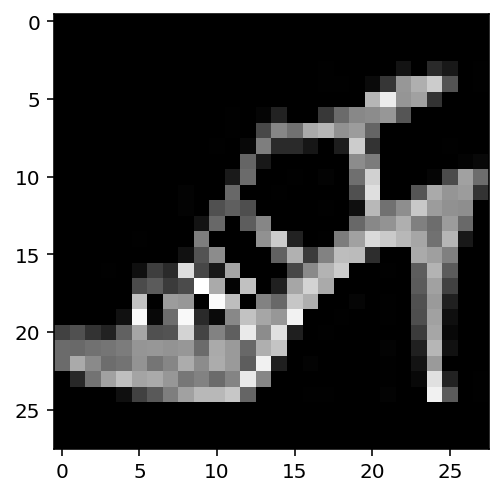

tensor([[1.4984e-08, 8.9192e-10, 8.9722e-10, 7.0550e-11, 4.6201e-11, 9.9963e-01,
         7.2384e-10, 3.6982e-04, 4.7775e-07, 8.9400e-07]],
       grad_fn=<ExpBackward>)
predict sandal


In [23]:
%matplotlib inline


images, labels = next(iter(testloader))
img = images[0].view(1, 784)
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

output = model(img)
ps = torch.exp(output)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
plt.show()
print(ps)
index_label = torch.argmax(ps)
index_label = index_label.numpy()
print('predict', labelNames[index_label])